# Setup

## Packages import

In [1]:
import time

import os
import numpy as np

import tensorflow as tf 
from tensorflow import keras
#tf.config.set_per_process_memory_growth(True)

import pickle

import collections
from collections import defaultdict
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Embedding, Reshape, Activation
from keras.layers import Concatenate, Conv2DTranspose, multiply, UpSampling2D
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils import Progbar
from keras.metrics import *
from keras import backend as K

import cv2

# Generator

## Architecture Definition

In [2]:
def generator(latent_dim = 100, n_classes = 3):
    # Initialize RandomNormal with mean = 0.0 and stddev = 0.02
    # init = RandomNormal(mean = 0.0, stddev = 0.02)
  
    ### Input 1: class label input ###
    
    # Generator take integer class label as input
    label_input = Input(shape = (1,))
    # print(label_input.shape)
    
    # Embedding layer: to convert class label integer to a vector of size 100
    y = Embedding(n_classes, 100)(label_input)
    # print('Embedding Layer: ', y.shape)
    
    # Dense layer with 7 x 7 units: to convert the vector to a 7 x 7 x 1 tensor
    n_nodes = 7 * 7
    y = Dense(n_nodes, kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(y)
    # print('Dense 1: ', y.shape)
    y = Reshape((7, 7 ,1))(y)
    print('reshape(final y shape): ', y.shape)

    ### Input 2: generator noise input ###
    
    # A latent_dim-dimensional vector is sampled from a normal distribution
    # with mean = 0.0 and stddev = 0.02 
    generator_input = Input(shape = (latent_dim,))
    
    # Noise vector is passed through a dense layer with 1024 * 7 * 7 units 
    # to produce a 7 x 7 x 1024 tensor
    n_nodes = 1024 * 7 * 7
    gen = Dense(n_nodes, 
                kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(generator_input)
    gen = Activation('relu')(gen)
    gen = Reshape((7, 7, 1024))(gen)
    print('Generator noise input: ', gen.shape)
    
    ### Concatenate both the inputs ###
    # The output tensors are then concatenated to produce a 7 × 7 × 1025 tensor. 
    merge = Concatenate()([gen, y])
    print('Concatenate(generator noise input and y: ', merge.shape)

    ### Upsampling ###
    # four successive transposed convolutions 
    # to produce tensors with dimensions 14 × 14 × 512, 28 × 28 × 256, 56 × 56 × 128 and 128 × 128 × 3, respectively.
    
    # (None, 7, 7, 1024) --> (None, 14, 14, 512)
    gen = Conv2DTranspose(512, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(merge)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print("(None, 7, 7, 1024) -> (None, 14, 14, 512): ", gen.shape)

    # (None, 14, 14, 512)  --> (None, 28, 28, 256)
    gen = Conv2DTranspose(256, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 14, 14, 512) -> (None, 28, 28, 256): ', gen.shape)

    # (None, 28, 28, 256) --> (None, 56, 56, 128)
    gen = Conv2DTranspose(128, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    gen = BatchNormalization(momentum = 0.9)(gen)
    gen = Activation("relu")(gen)
    print('(None, 28, 28, 256) -> (None, 56, 56, 128): ', gen.shape)

    # (None, 56, 56, 128) --> (None, 112, 112, 3)
    gen = Conv2DTranspose(3, kernel_size = (5, 5), strides = (2, 2), padding = "same", kernel_initializer = RandomNormal(mean = 0.0, stddev = 0.02))(gen)
    out_layer = Activation("tanh")(gen)
    print("(None, 56, 56, 128) -> (None, 112, 112, 3): ", out_layer.shape)
    
    # The final output from the generator is an fake image X of dimension 112 × 112 × 3
    model = Model(inputs = [generator_input, label_input], outputs = out_layer)
    return model

## Initialisation 

Initialising the generator by setting:
- A number of classes equal to 3 (COVID-19, pneumonia, normal)
- An input noise vector size of 100

In [3]:
generator_instance = generator(latent_dim = 100, n_classes = 3)

reshape(final y shape):  (None, 7, 7, 1)
Generator noise input:  (None, 7, 7, 1024)
Concatenate(generator noise input and y:  (None, 7, 7, 1025)
(None, 7, 7, 1024) -> (None, 14, 14, 512):  (None, 14, 14, 512)
(None, 14, 14, 512) -> (None, 28, 28, 256):  (None, 28, 28, 256)
(None, 28, 28, 256) -> (None, 56, 56, 128):  (None, 56, 56, 128)
(None, 56, 56, 128) -> (None, 112, 112, 3):  (None, 112, 112, 3)


## Loading weights of the best model

Importing the **best model**

In [31]:
epoch = 288
filename = f"./SaveDir/best_weights/params_generator_epoch_{epoch}.hdf5"

In [32]:
generator_instance.load_weights(filename)

# Functions

Function to generate two batches of size `batch_size` of:
- Randomly extracted noise vectors of `latent_dim` size
- Labels (0: COVID-19, 1: normal, 2: pneumonia)

In [33]:
def generate_batch_noise_and_labels(batch_size, latent_dim, n_classes = 3):

    # generate a new batch of noise
    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))

    # sample some labels
    sampled_labels = np.random.randint(0, n_classes, batch_size)

    return noise, sampled_labels

# Simple Generation

The noise vectors and their labels are passed to the generative model, the output images are normalised and displayed. 

In [34]:
seed_noise_rand, seed_labels_rand = generate_batch_noise_and_labels(batch_size=400, latent_dim=100)

def generate_images_test(model, noise, labels):
  name_map = {0:'COVID-19', 1:'normal', 2:'pneumonia'}
  generated_images_sample = model.predict([noise, labels.reshape((-1, 1))], verbose=0)
  norm_image = cv2.normalize((generated_images_sample + 1) * 127.5, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  norm_img = norm_image.astype(np.uint8)

  fig = plt.figure(figsize=(10, 10))

  for i in range(norm_img.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.title(name_map[labels[i]])
      plt.imshow(norm_img[i,:,:], cmap='gray')
      plt.axis('off')
  plt.show()

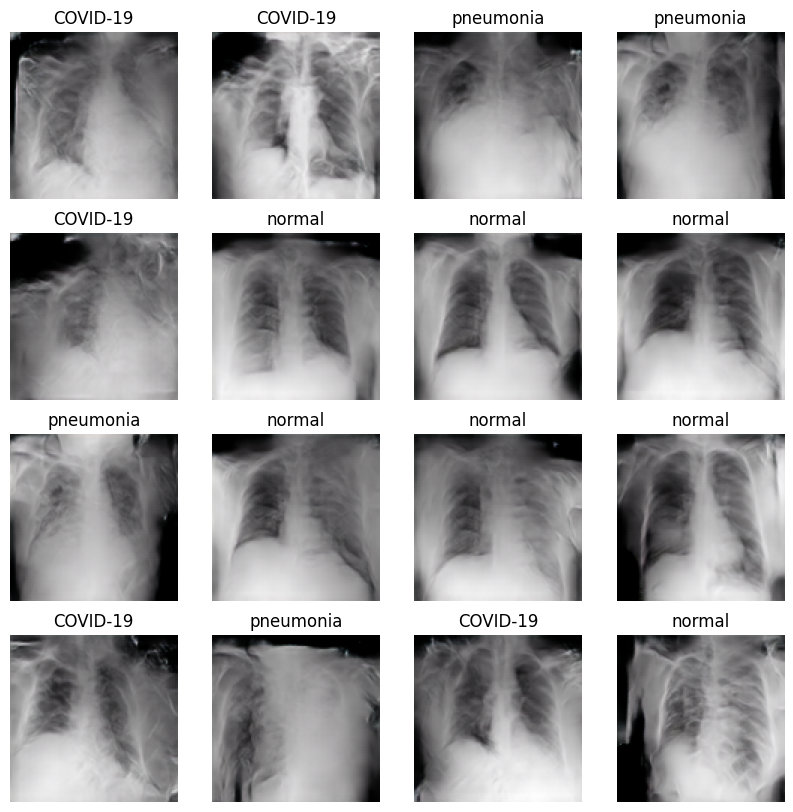

In [36]:
seed_noise_rand, seed_labels_rand = generate_batch_noise_and_labels(batch_size=16, latent_dim=100)
generate_images_test(generator_instance, seed_noise_rand, seed_labels_rand)